# Einleitung

Der folgende Code bildet ein Convolutional Neural Network. Es gibt 3 Phasen:
- Data preperation
- CNN model erstellen und evaluieren
- Die Ergebnisse auswerten

Es wird Keras verwendet. Für die Übersicht zu allen Keras befehlen siehe die Datei "keras cheatsheet" im Git repository.
Die Daten sehen folgendermaßen aus:

<img src="http://img1.imagilive.com/0717/mnist-sample.png" ></img>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# 1. Data preparation
Trainigs- und Testdaten laden

In [8]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

Die Trainingsdaten werden aufgeteilt in Pixeldaten (X_train) und der dazugehörigen Ziffer (Y_train)

In [9]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1) 

Optional: Anzahl der Trainingsdaten visualisieren

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

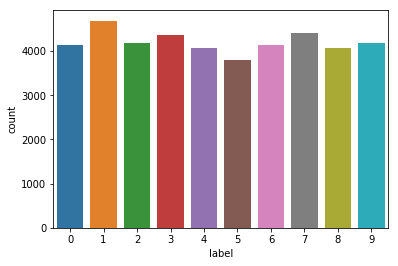

In [10]:
g = sns.countplot(Y_train)
Y_train.value_counts()

We have similar counts for the 10 digits.

Normalerweise wird jetzt das Datenset genauer analysiert (null-Werte etc.). Im Fall von MNIST sind alle Daten vollständig, daher wird dieser Schritt übersprungen. Die Daten werden aber normalisiert, das CNN wird damit schneller (Skala [0;1] statt [0;255])

In [11]:
X_train = X_train / 255.0
test = test / 255.0

### Reshape
Im nächsten Schritt werden die Trainingsdaten in die richtige Form gebracht. <br>
- Aktuell sind sie 1-dimensional, sie müssen 4-dimensional sein. <br>
- -1 bedeutet, dass die passende Zahl automatisch berechnet wird, sie entsprecht der Anzahl der Trainingsdaten. <br>
- Die vierte Dimension ist der Kanal, 1 bedeutet schwarz/weiß, eine 3 würde farbig (RGB) bedeuten.

In [12]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

# optional: Ziffer visualisieren
# h = plt.imshow(X_train[0][:,:,0])

print(X_train.shape)

(42000, 28, 28, 1)


### Label encoding
Format [0;9] nicht passend, es muss in "hot vectors" konvertiert werden. Der Grund ist, dass das CNN in diesem Format die Vorhersagen treffen wird.<br>
2 -> [0,0,1,0,0,0,0,0,0,0]

In [13]:
Y_train = to_categorical(Y_train, num_classes = 10)

# 3. CNN

An dieser Stelle kann experimentiert werden.
- Dropout hilft overfitting zu vermeiden
- Conv2D sind Convolutional Layer, die ein CNN ausmachen. Sie sind effektiv bei Bilderkennung
- Dense Layer ist ein "normales Layer" wie man es auf einem Bild von einem NN sieht (alle Knoten sind verbunden)
- Am Ende sollte immer eine softmax Funktion stehen, sie konvertiert die Werte zu Wahrscheinlichkeiten

In [21]:
model = Sequential()

# Convolutions
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))

# Fully connected 
model.add(Flatten())

# Softmax um Wahrscheinlichkeiten zu erhalten
model.add(Dense(10, activation = "softmax"))
model.add(Dropout(0.30))


Das model kompilieren. Die Werte können so übernommen werden, Alternativen stehen im Keras Cheat Sheet.

In [22]:
model.compile(optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0), 
              loss = "categorical_crossentropy", 
              metrics=["accuracy"])

In [23]:
epochs = 3  # je höher die Anzahl der epochs (= Trainingsdurchläufe) desto mehr trainiert das model.
batch_size = 86

# Fit the model
history = model.fit(X_train,
                    Y_train, 
                    batch_size=batch_size,
                    epochs = epochs,
                    verbose = 2)

Epoch 1/1
 - 78s - loss: 0.2216 - acc: 0.9318


# Evaluation
Der Code zeigt die "Confusion Matrix". Dort ist zu sehen, welche Fehler das CNN macht. Das CNN bewertet die Testdaten und es wird die Vorhersage mit dem tatsächlichen Label (von der ersten Spalte) verglichen. Bei Fehler visualisieren werden die größten Fehler gesucht (größte Differenz zwischen Vorhersage und tatsächlichem Label).

## Confusion Matrix

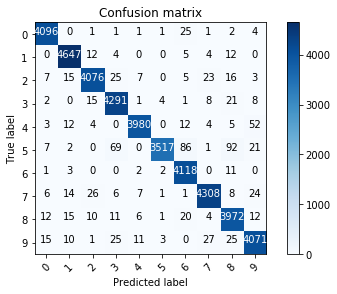

In [17]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(X_train)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_train,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

### Fehler visualisieren

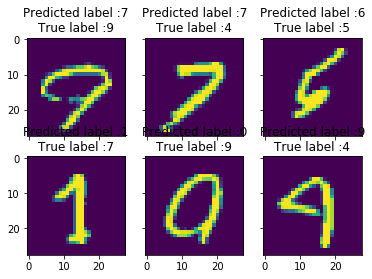

In [18]:
# Vorhersage ist anders als das tatsächliche Eregebnis
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_train_errors = X_train[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_train_errors, Y_pred_classes_errors, Y_true_errors)

### Ergebnisse vorhersagen

In [19]:
print(test.shape)
results = model.predict(test) # das model gibt die Wahrscheinlichkeiten an
results = np.argmax(results,axis = 1) # die höchste Wahrscheinlichkeit wird ausgewählt

(28000, 28, 28, 1)


## Einzelnes Bild vorhersagen
Das einzelne muss erst wieder in die 4-D form mit hilfe von .reshape() gebracht werden.

In [20]:
to_predict = X_train[0].reshape(1,28,28,1)
print(to_predict.shape)
print(model.predict(to_predict))

(1, 28, 28, 1)
[[9.7031370e-06 9.9787271e-01 3.5982404e-04 1.4483384e-05 1.2953665e-04
  5.3733761e-06 6.1577838e-04 1.5335976e-05 9.7603776e-04 1.0337327e-06]]


In [ ]:
## hilfreiche numpy methoden

## Optional: Data Augmentation / Learning rate annealer

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [10]:
# Set a learning rate annealer
larning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                             patience=3, 
                                           verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [2]:
# visualize training data
w=10
h=10

fig=plt.figure(figsize=(28, 28))

columns = 10
rows = 15
for i in range(1, columns*rows +1):
    img = np.random.randint(1000, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[i][:,:,0])
plt.show()

ModuleNotFoundError: No module named 'plt'

In [3]:
print(X_train)

NameError: name 'X_train' is not defined